In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision

#from sklearn.metrics import accuracy_score, f1_score, recall_score

In [2]:
import os 
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
%load_ext autoreload
%autoreload 2

### set data file locations

In [4]:
data_path = r"data"

In [5]:
imgs = os.listdir(data_path)

### set calc location

In [6]:
if torch.cuda.is_available():  
    dev = "cuda:1" 
else:  
    dev = "cpu"  
device = torch.device(dev)
device = torch.device('cpu')

### load model

In [27]:
import torchvision.models as models

net = models.resnet101(pretrained=True)
net.to(device)
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

### load and transform data

In [29]:
from torchvision import transforms
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

In [51]:
import webp
img = webp.load_image(os.path.join(data_path, imgs[2]), 'RGB')

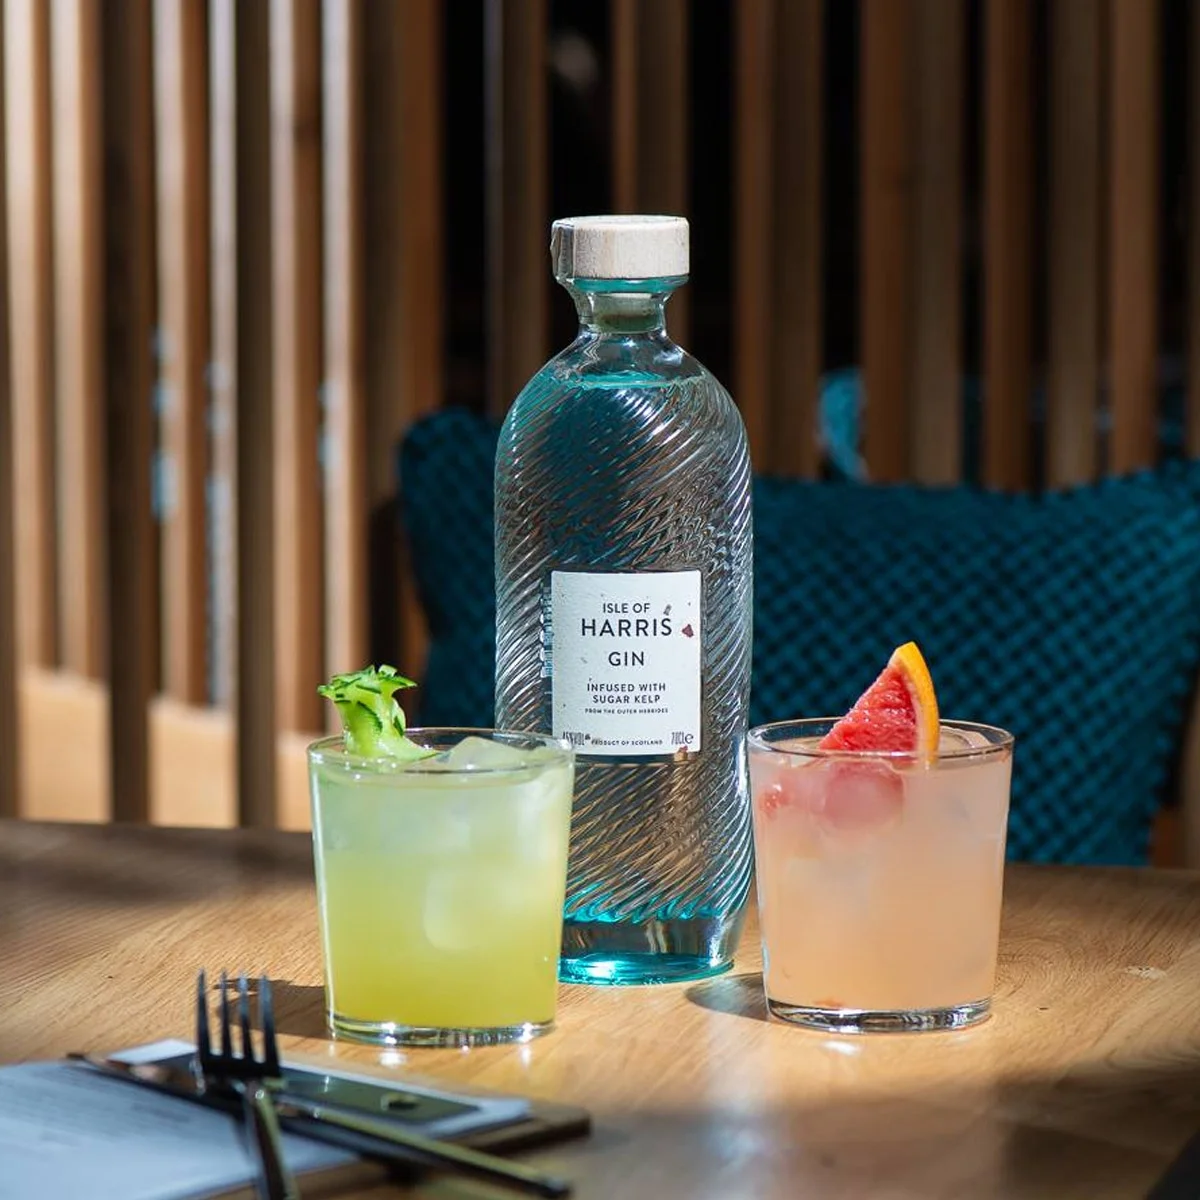

In [52]:
img

In [53]:
output = net(transform(img).unsqueeze(0))

### test model inference

In [54]:
with open("imagenet_classes_to_labels_map.txt") as f:
    labels = eval(f.read())

# Forth, print the top 5 classes predicted by the model
_, indices = torch.sort(output[[0][:]], descending=True)
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
[(labels[idx.item()], percentage[idx].item()) for idx in indices[0][:10]]

[('eggnog', 23.729185104370117),
 ('water bottle', 15.928043365478516),
 ('water jug', 14.167654037475586),
 ('beaker', 12.534811019897461),
 ('cocktail shaker', 7.022706985473633),
 ('measuring cup', 3.187483549118042),
 ('perfume, essence', 2.8960049152374268),
 ('lotion', 2.893685817718506),
 ('tray', 1.3463205099105835),
 ('wine bottle', 1.0518288612365723)]

### amend base model

In [22]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [23]:
feature_extract = True
set_parameter_requires_grad(net, feature_extracting=feature_extract)
num_ftrs = net.classifier[6].in_features
net.classifier[6] = nn.Linear(num_ftrs, len(lb_cols))
#net.classifier.add_module('7', nn.Sigmoid())

In [24]:
net.to(device)
net.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [25]:
params_to_update = net.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in net.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in net.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias
